<a href="https://colab.research.google.com/github/StefanHubner/MachineLearningEconomics/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
Sys.setenv("CUDA" = "cpu")
Sys.setenv("TORCH_INSTALL" = "1")
install.packages("torch", reinstall = FALSE)
torch::install_torch()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘coro’




In [3]:
install.packages("torchvision")
install.packages("luz")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘jpeg’, ‘png’, ‘abind’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’




In [4]:
library(torch)       # computing library
library(torchvision) # for dataset
library(luz)
library(magrittr)
library(coro)

In [17]:
# Load MNIST dataset
train_dataset <- mnist_dataset(
  ".",
  download = TRUE,
  train = TRUE,
  transform = transform_to_tensor
)

test_dataset <- mnist_dataset(
  ".",
  download = TRUE,
  train = FALSE,
  transform = transform_to_tensor
)

# Data Loader
train_dl <- dataloader(train_dataset, batch_size = 64)
test_dl <- dataloader(test_dataset, batch_size = 64)

Warning message in rasterImage(x, 0, 0, ncol(x), nrow(x), ...):
“"axes" is not a graphical parameter”


[1] 6

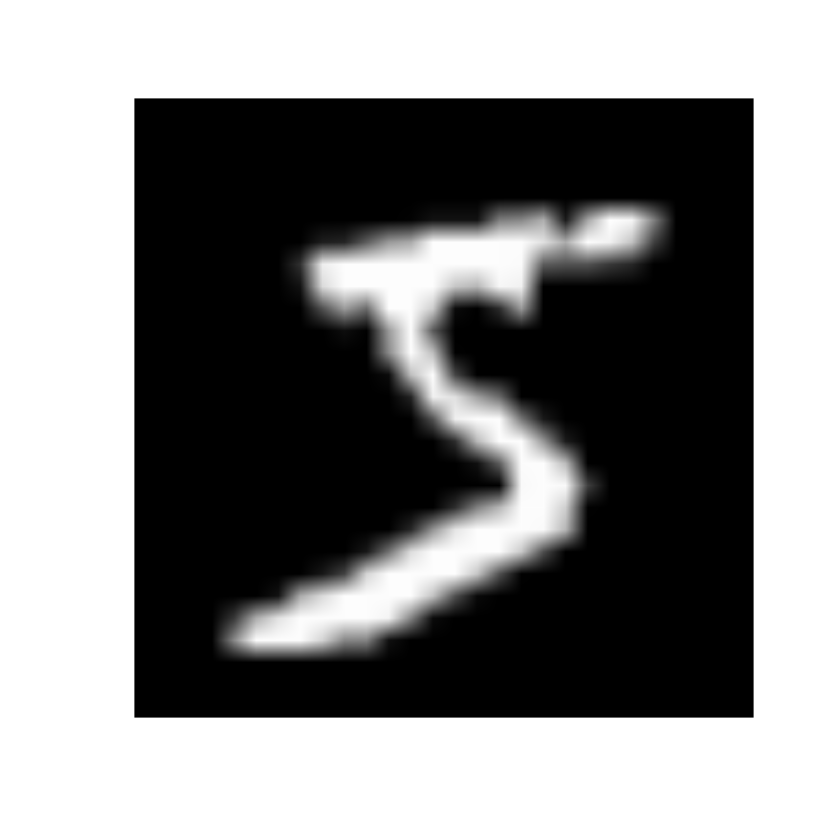

In [29]:
# Assuming train_dataset is already loaded and is a dataset of MNIST images
# Extract the first image data
idx <- 1

image_data <- train_dataset$data[idx, , ]

# Convert the tensor to a matrix
image_matrix <- as.array(image_data)

# Plot the image
plot(as.raster(image_matrix / 255), axes = FALSE, col = grey.colors(256))

train_dl$dataset[idx]$y # this is really y+1

In [30]:
# Define the neural network
net <- nn_module(
  "Net",
  initialize = function() {
    self$fc1 <- nn_linear(784, 256)
    self$fc2 <- nn_linear(256, 128)
    self$fc3 <- nn_linear(128, 10)
  },
  forward = function(x) {
    x <- x$view(c(-1, 784)) # Flatten the images
    x %>%
      self$fc1() %>%
      nnf_relu() %>%
      self$fc2() %>%
      nnf_relu() %>%
      self$fc3()
  }
)

# Instantiate the model
model <- net()

# Define the loss function and optimizer
loss_fn <- nn_cross_entropy_loss()
optimizer <- optim_adam(model$parameters)

In [32]:
# Training function
train_batch <- function(b, model, loss_fn, optimizer) {
  optimizer$zero_grad() # Reset gradients from previous operations
  output <- model(b$x) # Forward pass: compute the model's output
  loss <- loss_fn(output, b$y) # Compute loss: how far off our predictions are
  loss$backward() # Backward pass: compute gradients of loss w.r.t. model parameters
  optimizer$step() # Update model parameters based on gradients
  loss$item() # Return the loss value as a number
}

# Training loop
num_epochs <- 5

for (epoch in 1:num_epochs) {
  model$train()
  total_loss <- 0
  total <- 0

  loop(for (b in train_dl) { # batches (observations, here)
    loss <- train_batch(b, model, loss_fn, optimizer)
    total_loss <- total_loss + loss
    total <- total + 1
  })

  avg_loss <- total_loss / total
  cat(sprintf("Epoch: %d, Loss: %.4f\n", epoch, avg_loss))
}

# Save the trained model
torch_save(model, "mnist_model.pt")

Epoch: 1, Loss: 0.2284
Epoch: 2, Loss: 0.1106
Epoch: 3, Loss: 0.0717
Epoch: 4, Loss: 0.0489
Epoch: 5, Loss: 0.0349


In [64]:
# Validation function
validate_model <- function(model, test_dl, loss_fn) {
  model$eval()  # Set the model to evaluation mode
  total_loss <- 0
  total_accuracy <- 0
  total_count <- 0

  loop(for (b in test_dl) {
    output <- model(b$x)

    # Convert output to probabilities and get the predicted class (index of max value)
    probabilities <- nnf_softmax(output, dim = 2)
    predicted <- torch_max(probabilities, dim = 2)

    correct <- sum(predicted[[2]]  == b$y)
    total_accuracy <- total_accuracy + correct
    total_count <- total_count + length(b$y)
  })

  avg_accuracy <- total_accuracy / total_count * 100
  cat(sprintf("Validation Loss: Accuracy: %.2f%%\n", avg_accuracy))
}

# Run validation after training
validate_model(model, test_dl, loss_fn)

Validation Loss: Accuracy: 96.24%
